## Variational Quantum Eigensolver - Kris McBrian

Find and compare the ground state energy of a 2x2 matrix using
a quantum circuit and analytical methods

In [174]:
import qiskit as qk
from qiskit.visualization import plot_histogram
import numpy  as np
import matplotlib.pyplot as plt

num_values = 30 # number of angles to evaluate expectation value
backend = qk.Aer.get_backend('qasm_simulator')
n_shots = 2**15 # number of measurments per angle

# Coefficients of Hamiltonian
a = 1.0  # | a+b   c-id |
b = 1.0  # | c+id  a-b  |
c = 1.0
d = 1.0

A = np.array([[a+b, np.complex(c,-d)], [np.complex(c,d), a-b]],dtype=complex)

### Define Hamiltonian and experimental expectation values

In [175]:
def H(Z,X,Y,a,b,c,d):
    return a + b*Z + c*X + d*Y

# called at the end of circuit function
def exp_value(eig, results, n_shots):
    avg = 0.
    # for every result that was measured
    for a in results.keys():
        # obtain index by converting binary measurement to integer
        b = int(a,2)    # e.g. '10' eigenvalue stored at index 2 of eig
        # weighted sum of eigenvalues and number of measurments
        avg += eig[b]*results[a]
    return avg / n_shots

### Functions for analytical expectation values and Ground State energy
Found by first finding state $|\psi\rangle = Rz(\phi)Ry(\theta)|0\rangle$

then plugging into $\langle O \rangle = \langle\psi | O | \psi \rangle$

In [176]:
# Expectation value of Z
def Z_analytic(theta):
    return np.cos(theta/2)**2 - np.sin(theta/2)**2

# Expectation value of X
def X_analytic(theta,phi):
    return np.sin(theta)*np.cos(phi)

# Expectation value of Y
def Y_analytic(theta,phi):
    return np.sin(theta)*np.cos(phi-np.pi/2)

### Circuit to take experimental measurements for expectation values
Rotate $|0\rangle$ state about the y-axis by the angle $\theta$ and about the z-axis by the angle $\phi$, then take measurements in X, Y, and Z

In [177]:
def circuit(theta,phi, n_shots):

    qc = qk.QuantumCircuit(3,3)

    # Rotation applied to each qubit
    qc.ry(theta,0)
    qc.ry(theta,1)
    qc.ry(theta,2)
    
    qc.rz(phi,0)
    qc.rz(phi,1)
    qc.rz(phi,2)
    
    # Rotation for x-measurement
    qc.h(1)

    # Rotation for y-measurement
    qc.sdg(2)
    qc.h(2)

    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)

    exp_values = qk.execute(qc, backend, shots=n_shots)
    results = exp_values.result().get_counts()

    # array constructed of eigenvalue corresponding the binary representation of index
    #   [0,1,2,3] --> [000,001,010,011] --> (0's to -1's)
    y = exp_value([1,1,1,1,-1,-1,-1,-1],results,n_shots) #leading bit
    x = exp_value([1,1,-1,-1,1,1,-1,-1],results,n_shots) # middle bit
    z = exp_value([1,-1,1,-1,1,-1,1,-1],results,n_shots) # trailing bit

    return np.array([z,x,y])

In [178]:
theta = np.linspace(0,np.pi,num_values)
phi = np.linspace(0,2*np.pi,num_values)

x_experiment = np.zeros((num_values,num_values))
z_experiment = np.zeros((num_values,num_values))
y_experiment = np.zeros((num_values,num_values))
x_theory = np.zeros((num_values,num_values))
y_theory = np.zeros((num_values,num_values))
z_theory = np.zeros((num_values,num_values))

H_experiment = np.zeros((num_values,num_values))
H_theory = np.zeros((num_values,num_values))

### Evaluate circuits and analytical solution

In [180]:
for i in range(num_values):
    for j in range(num_values):
    # Get expectation values for X,Y, & Z
        z_experiment[i][j],x_experiment[i][j],y_experiment[i][j] = circuit(theta[i],phi[j],n_shots)
        # Evaluatate < H >
        H_experiment[i][j] = H(z_experiment[i][j], x_experiment[i][j],y_experiment[i][j], a, b,c,d)
    
        # Evaluate < X >, < Y >, < Z >, and < H > analytically
        x_theory[i][j] = X_analytic(theta[i],phi[j])
        y_theory[i][j] = Y_analytic(theta[i],phi[j])
        z_theory[i][j] = Z_analytic(theta[i])
        H_theory[i][j] = H(z_theory[i][j], x_theory[i][j],y_theory[i][j], a,b,c,d)
                                   

### Results

Ground State Eigen-energy           = -0.73205 
Ground state from Circuit           = -0.73370
Ground state from Analytic solution = -0.73129


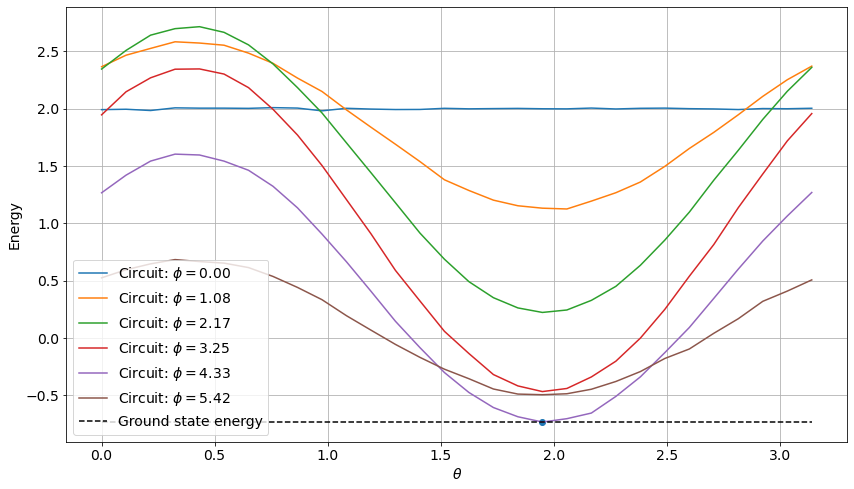

In [188]:
eigen_energies = np.linalg.eigvalsh(A)
print('Ground State Eigen-energy           = %.5f '%eigen_energies[0])

def array_min(A):
    val = 0
    for i_theta in range(num_values):
        for i_phi in range(num_values):
             if(A[i_phi][i_theta] < val):
                    min_theta = i_theta
                    min_phi = i_phi
                    val = A[i_phi][i_theta]
    return [min_theta,min_phi,val]

circuit_min = array_min(H_experiment)
theory_min  = array_min(H_theory)

        
print("Ground state from Circuit           = %.5f"%H_experiment[circuit_min[1]][circuit_min[0]])
print("Ground state from Analytic solution = %.5f"%H_theory[theory_min[1]][theory_min[0]])

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,8))
for i in range(0,num_values,5):
    plt.plot(theta,H_experiment[i][:],label=r'Circuit: $\phi=%.2f$'%phi[i])
    #plt.plot(theta,H_theory[i][:],label=r'Theory: $\phi=%.2f$'%phi[i])
plt.plot(theta,np.ones(num_values)*eigen_energies[0], 'k--',label='Ground state energy')
plt.scatter(theta[circuit_min[0]],H_experiment[circuit_min[1]][circuit_min[0]])
plt.legend()
plt.grid()
plt.xlabel(r'$\theta$')
plt.ylabel('Energy')
plt.show()